In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
print(os.listdir(path))
rcParams['figure.figsize'] = 16,4

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_1.csv', '20190103_2.csv', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', 'accurate.xlsx', 'comments.txt', 'dot_result.csv', 'feature_importance.png', 'rmse1.csv', 'test.csv', 'test_predict.png']


In [2]:
dot_data_1 = pd.read_excel(path + '20190103_点部取货量_1.xlsx', parse_dates=[1])
dot_data_2 = pd.read_excel(path + '20190103_点部取货量_2.xlsx', parse_dates = [1])

In [3]:
# dot_data_1 = pd.read_csv(path + '20190103_1.csv', encoding = 'utf-8')
# dot_data_2 = pd.read_csv(path + '20190103_2.csv', encoding = 'utf-8')

In [4]:
dot_data = pd.concat([dot_data_1,dot_data_2],ignore_index = True)
data = dot_data.copy()
data.head()

,dot,order_date,order_num,num,jifei_weight,shiji_weight,longitude,latitude
0,13825092291,2017-05-23,1,1,1.0,1.0,NaN,NaN
1,15102680258,2017-06-06,1,1,1.0,1.0,NaN,NaN
2,ERP客户系统组,2017-06-09,1,1,3.0,3.0,NaN,NaN
3,IT采购组,2017-04-13,8,8,8.0,8.0,NaN,NaN
4,IT采购组,2017-05-03,4,5,10.0,10.0,NaN,NaN


In [5]:
data = data.drop(['num', 'jifei_weight', 'shiji_weight', 'longitude', 'latitude'], axis = 1)

In [6]:
data_ts = data.copy()
data_ts.index = pd.to_datetime(data['order_date'])
data_ts.head()

,dot,order_date,order_num
order_date,,,
2017-05-23,13825092291,2017-05-23,1
2017-06-06,15102680258,2017-06-06,1
2017-06-09,ERP客户系统组,2017-06-09,1
2017-04-13,IT采购组,2017-04-13,8
2017-05-03,IT采购组,2017-05-03,4


In [7]:
data_ts.sort_index(ascending = True, inplace = True)
tmp = data_ts['2017-12':]
len(tmp[tmp['dot'] == '东丽点部'])

412

In [8]:
data_count = pd.DataFrame(tmp['order_date'].groupby(tmp['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 390, ['dot']]
useful_dot_name.head(5)

,dot
58,东丽中心庄点部
62,东丽塘沽点部
63,东丽宁河点部
66,东丽机场点部
70,东丽津塘点部


In [9]:
result_data = tmp.loc[tmp['dot'].isin(useful_dot_name['dot'])]
result_data.head()

,dot,order_date,order_num
order_date,,,
2017-11-01,宁海桃源点部,2017-11-01,61
2017-11-01,温州娄桥点部,2017-11-01,110
2017-11-01,寮步凫山点部,2017-11-01,16
2017-11-01,惠山玉祁点部,2017-11-01,31
2017-11-01,寮步华为点部,2017-11-01,24


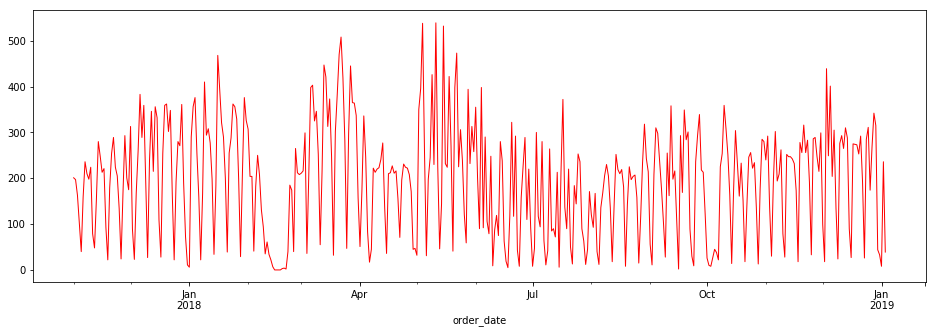

In [10]:
result_ts = result_data.loc[result_data['dot'] == '坂田上雪点部', ['order_num']]
# result_ts = np.log(result_ts)
result_ts = result_ts['order_num'].resample('D').sum()
result_ts.plot(figsize = (16,5), color = 'r', linewidth=1)
# pd.DataFrame(result_ts).reset_index(drop = True).boxplot()

In [11]:
result_ts_train = result_ts[ : -30]
result_ts_test = result_ts[-30 : ]
result_ts_train.head(3).append(result_ts_train.tail(3))

order_date
2017-11-01    201
2017-11-02    197
2017-11-03    163
2018-12-02     18
2018-12-03    439
2018-12-04    249
Name: order_num, dtype: int64

## 白噪声检验

In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox
def test_stochastic(ts,lag):
    p_value = acorr_ljungbox(ts, lags=lag) #lags可自定义
    return p_value
test_stochastic(result_ts_train,1)[1][0]

5.424570003459356e-12

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(result_ts_train, model = "additive")
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

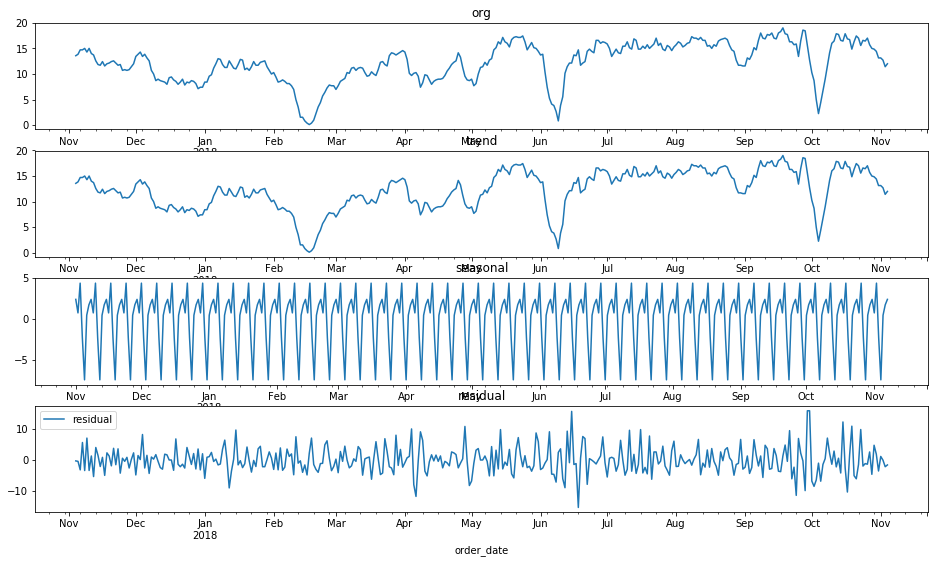

In [16]:
fig = plt.figure(figsize = (16,9))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
trend.plot(label = 'org', ax = ax1, title = 'org')
trend.plot(label = 'trend', ax = ax2, title = 'trend')
seasonal.plot(label = 'seasonal', ax = ax3, title = 'seasonal')
residual.plot(label = 'residual', ax = ax4, title = 'residual')
plt.legend(loc = 'best')

In [22]:
dftest = adfuller(result_ts_train)
output = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    output['Critical Value (%s)' % key] = value
output

Test Statistic                  -3.742627
p-value                          0.003552
#Lags Used                      17.000000
Number of Observations Used    354.000000
Critical Value (1%)             -3.448958
Critical Value (5%)             -2.869739
Critical Value (10%)            -2.571138
dtype: float64

Text(0.5,1,'Partial Autocorrelation Function')

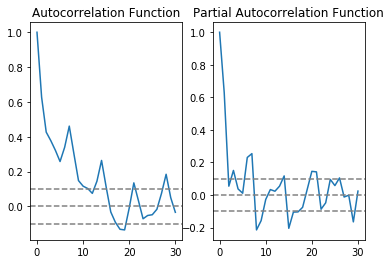

In [15]:
lag_acf = acf(result_ts_train, nlags = 30)
lag_pacf = pacf(result_ts_train, nlags = 30)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(result_ts_train)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(result_ts_train)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(result_ts_train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(result_ts_train)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

In [23]:
import warnings
warnings.filterwarnings("ignore")
temp = {}
for p in range(0,6):
    for q in range(0,6):
        try:
            temp[str(p) + '_' + str(q)] = (ARMA(result_ts_train, order=(p, q)).fit().aic)
        except:
            continue
tmp = sorted(temp.items(), key = lambda x : x[1], reverse = False)
p, q = tmp[0][0].split('_')
print(p, q)

5 4


In [24]:
arma_model = ARMA(result_ts_train, order = (int(p), int(q))).fit()

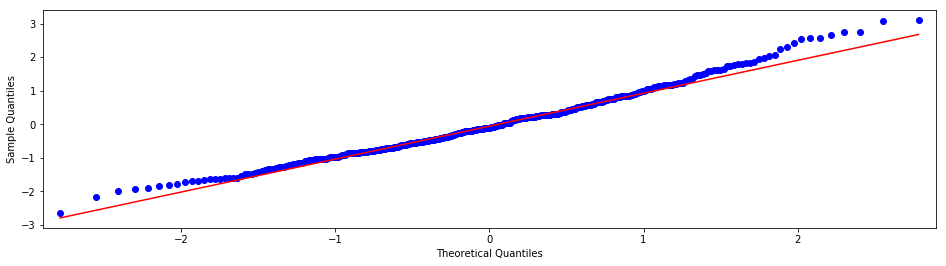

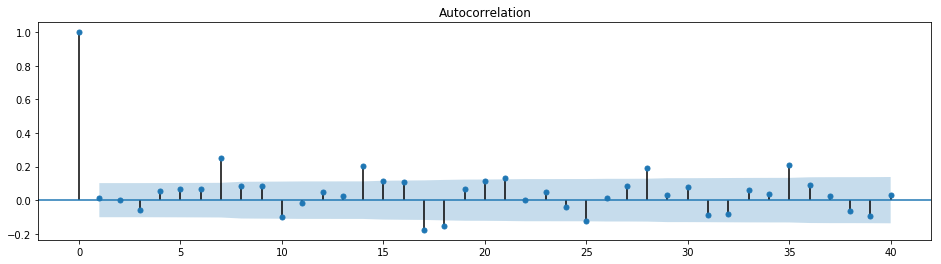

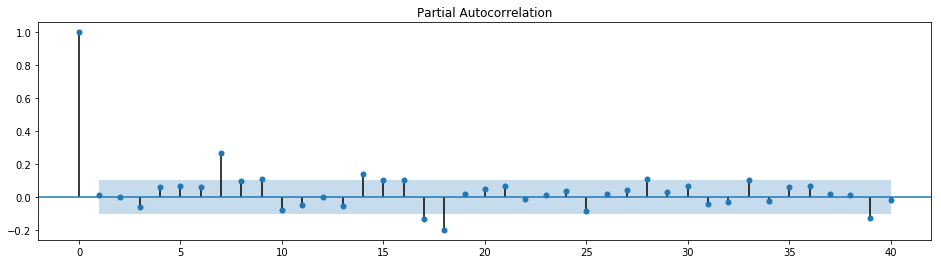

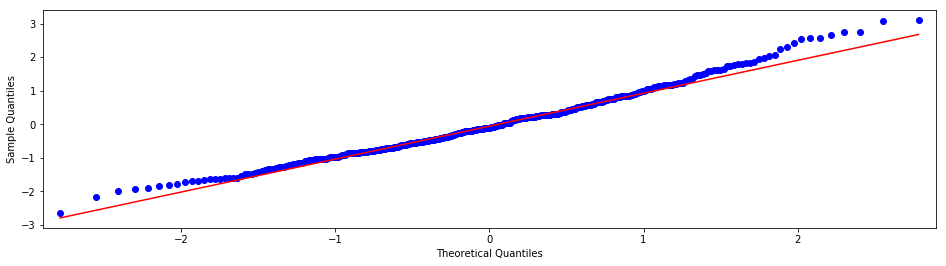

In [24]:
from statsmodels.graphics.api import qqplot
resid = arma_model.resid
plot_acf(resid.squeeze(), lags=40)
plot_pacf(resid, lags=40)
qqplot(resid, line='q', fit=True)

In [25]:
arma_result = arma_model.predict()

Text(0.5,1,'TRAIN_RSME : 85.6580')

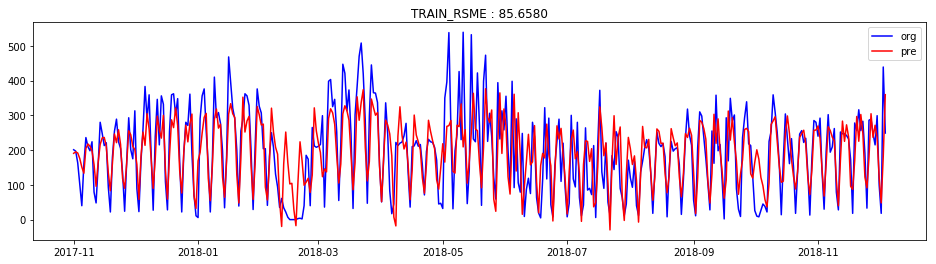

In [26]:
plt.plot(result_ts_train, label = 'org', color = 'b')
plt.plot(arma_result, label = 'pre', color = 'r')
plt.legend(loc = 'best')
plt.title("TRAIN_RSME : %.4f" % np.sqrt(np.sum((arma_result - result_ts_train) ** 2)/len(result_ts_train)))

In [27]:
test_result = arma_model.predict(result_ts_test.index[0].strftime('%Y-%m-%d'), result_ts_test.index[-1].strftime('%Y-%m-%d'), dynamic = True)

Text(0.5,1,'TEST_RSME : 100.1526')

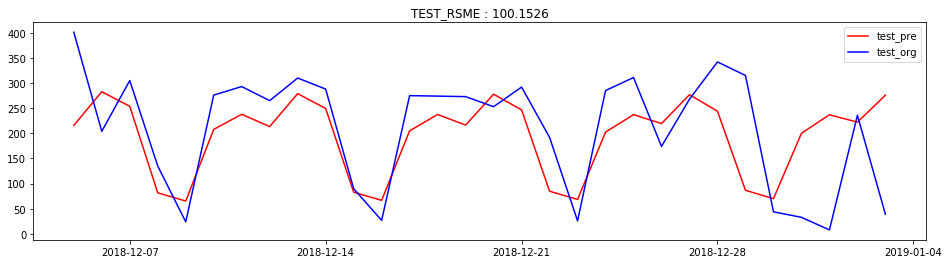

In [28]:
plt.plot(test_result, label = 'test_pre', color = 'r')
plt.plot(result_ts_test, label = 'test_org', color = 'b')
plt.legend(loc = 'best')
plt.title("TEST_RSME : %.4f" % np.sqrt(np.sum((result_ts_test - test_result) ** 2)/len(test_result)))

In [ ]:
result_ts_test,test_result，accurate

In [66]:
accurate = []
dot = 'aaa'
for i in range(len(test_result)):
  accurate.append(min(test_result[i], result_ts_test[i]) / max(test_result[i], result_ts_test[i]))
df_accurate = pd.concat([pd.DataFrame(result_ts_test.index, columns = ['order_date']), pd.DataFrame(accurate, columns = ['acc_rate'])], axis = 1)
# print(df_accurate)
df_dot = pd.DataFrame(np.repeat(dot, len(test_result)), columns=['dot'])
# print(df_dot)
# 合并实际值和预测值
order_num = pd.concat([pd.DataFrame(result_ts_test), pd.DataFrame(test_result)], axis=1)
order_num.columns = ['y_truth', 'y_predict']
order_num = order_num.reset_index(drop=True)
# print(order_num)

dot_acc_rate = pd.concat([df_dot, df_accurate, order_num], axis=1)
print(dot_acc_rate)
dot_acc_rate = dot_acc_rate[['dot', 'order_date', 'y_truth', 'y_predict', 'acc_rate']]
print("Mean acc_rate : %.4f" % df_accurate.acc_rate.mean())
 

    dot order_date  acc_rate  y_truth  y_predict
0   aaa 2018-11-05  0.000000        0   1.731441
1   aaa 2018-11-06  0.543014        2   3.683149
2   aaa 2018-11-07  0.604696        2   3.307448
3   aaa 2018-11-08  0.000000        0   4.317573
4   aaa 2018-11-09  0.742960        2   2.691936
5   aaa 2018-11-10  0.690212        4   2.760848
6   aaa 2018-11-11  0.000000        0   1.517205
7   aaa 2018-11-12  0.677907        4   2.711628
8   aaa 2018-11-13  0.461444        6   2.768664
9   aaa 2018-11-14  0.953273        4   4.196068
10  aaa 2018-11-15  0.286116        1   3.495089
11  aaa 2018-11-16  0.875881        4   3.503526
12  aaa 2018-11-17  0.672568        3   2.017704
13  aaa 2018-11-18  0.000000        0   2.248117
14  aaa 2018-11-19  0.676934        3   2.030802
15  aaa 2018-11-20  0.856369        4   3.425477
16  aaa 2018-11-21  0.596670        6   3.580021
17  aaa 2018-11-22  0.585171        7   4.096197
18  aaa 2018-11-23  0.338740        1   2.952118
19  aaa 2018-11-24  

In [53]:
a = pd.concat([pd.DataFrame(result_ts_test), pd.DataFrame(test_result)], axis = 1)
a.columns = ['y_truth', 'y_predict']
# a = a.reset_index(drop=True)
a

,y_truth,y_predict
order_date,,
2018-11-05,0,1.731441
2018-11-06,2,3.683149
2018-11-07,2,3.307448
2018-11-08,0,4.317573
2018-11-09,2,2.691936
2018-11-10,4,2.760848
2018-11-11,0,1.517205
2018-11-12,4,2.711628
2018-11-13,6,2.768664


## 时间序列预测准确率

In [26]:
accurate=[]
for i in range(len(test_result)):
     accurate.append(min(test_result[i], result_ts_test[i])/max(test_result[i], result_ts_test[i]))
accurate = pd.DataFrame(accurate, index = result_ts_test.index, columns = ['acc_rate'])
print("Mean acc_rate : %.4f" % accurate.acc_rate.mean())
# accurate

Mean acc_rate : -inf


In [119]:
"平均百分比误差(MEP) = " + str(np.sum((result_ts_test - test_result)/result_ts_test*100)/len(test_result))

'平均百分比误差(MEP) = -23.413434442848803'

In [120]:
"平均绝对百分比误差(MAEP) = " + str(np.sum(abs(result_ts_test - test_result)/result_ts_test*100)/len(test_result))

'平均绝对百分比误差(MAEP) = 35.13416406676433'

## 移动平均准确率

In [25]:
accurate=[]
for i in range(len(result_ts_test_rol)):
     accurate.append(min(test_result[i], result_ts_test_rol[i])/max(test_result[i], result_ts_test_rol[i]))
accurate = pd.DataFrame(accurate, index = result_ts_test_rol.index, columns = ['acc_rate'])
print("Mean acc_rate : %.4f" % accurate.acc_rate.mean())

NameError: name 'result_ts_test_rol' is not defined

In [62]:
for w in range(3, 30):
    result_ts_rol = result_ts.rolling(window = w).mean()
    result_ts_test_rol = result_ts_rol['2018-11-04':]
    accurate=[]
    for i in range(len(test_result)):
         accurate.append(min(test_result[i], result_ts_test_rol[i])/max(test_result[i], result_ts_test_rol[i]))
    accurate = pd.DataFrame(accurate, index = result_ts_test_rol.index, columns = ['acc_rate'])
    print(w, accurate.acc_rate.mean())

3 0.8916094238596571
4 0.8900331972398837
5 0.8866512137697191
6 0.8853838398380112
7 0.893753965854064
8 0.9061489853713077
9 0.9148667269828169
10 0.9123084579574657
11 0.9068861259226423
12 0.9020371259300768
13 0.8983683207408443
14 0.9013480784592933
15 0.9087903597927339
16 0.9141326064741836
17 0.9122384570738902
18 0.9088984054211959
19 0.9047160874931114
20 0.9013416956629409
21 0.903879764557402
22 0.9082652489770318
23 0.9118044950345072
24 0.9098105686622523
25 0.9079518987620456
26 0.9059196026872207
27 0.90345659664996
28 0.9051049635147876
29 0.9082199296247812
